<a href="https://colab.research.google.com/github/jjrodcast/SocialDistanceDetector/blob/master/Project_Social_Distance_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### 1. Capturamos el primer frame para obtener la matríz de homografía



In [5]:
capture = cv2.VideoCapture('TownCentreXVID.avi')
ret, frame = capture.read()
print(ret)
cv2.imwrite('calibration_frame.jpg', frame)
capture.release()

True


Image size:  (1080, 1920, 3)


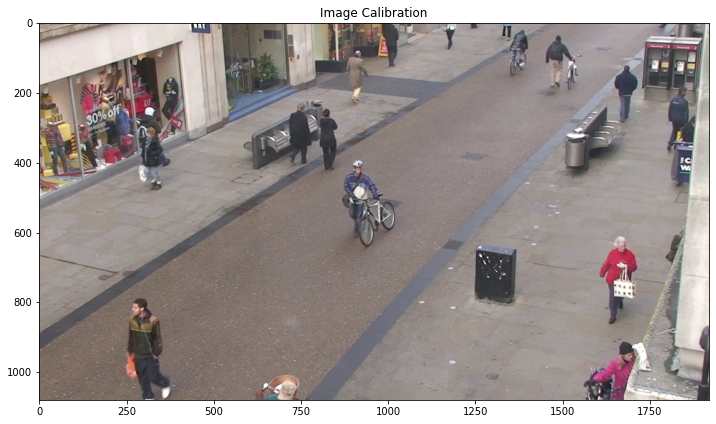

In [169]:
image_original = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB) 
image_calibration = image_original.copy()
print("Image size: ", image_calibration.shape)
plt.figure(figsize=(12, 12))
plt.title("Image Calibration")
plt.imshow(image_calibration)
plt.show()

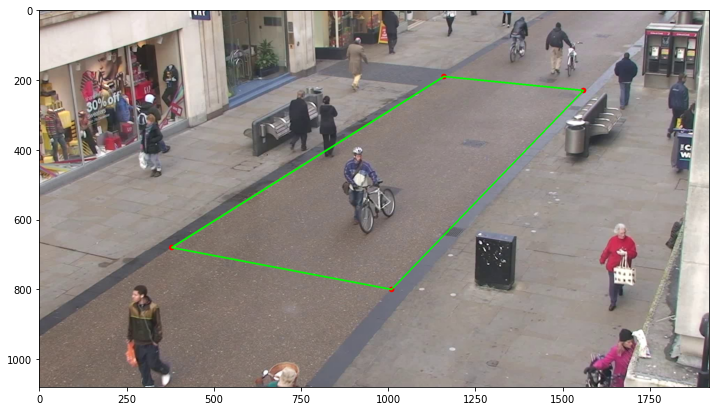

In [170]:
# Finding points on the calibration image
source_points = np.float32([[1160, 190], [1560, 230], [1010, 800], [380, 680]])
image_calibration_points = image_calibration.copy()

# Drawing points from calibration image
for point in source_points:
  cv2.circle(image_calibration_points, tuple(point), 8, (255, 0, 0), -1)

# Drawing lines to join the points
points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(image_calibration_points, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(image_calibration_points)
plt.show()

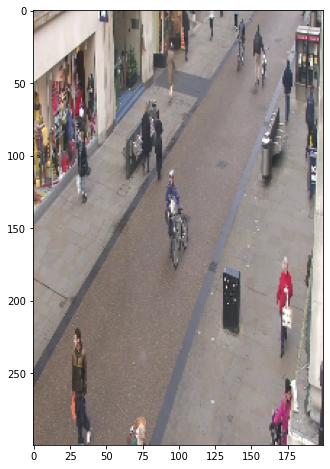

In [167]:
# Mapping to other perspective
width = 200
height = 300

# Finding points to destination perspective
(img_height, img_width) = image_calibration.shape[:2]
src_points = np.float32([[0, 0], [img_width, 0], [img_width, img_height], [0, img_height]])
dest_points = np.float32([[0,0], [width, 0], [width, height], [0, height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(src_points, dest_points)
result = cv2.warpPerspective(image_calibration, matrix, (width, height))

#plt.rc('grid', linestyle='-', color='blue')
plt.figure(figsize=(8, 8))
plt.imshow(result)
#plt.yticks(np.arange(0, 300, step=10))
#plt.xticks(np.arange(0, 200, step=10))
#plt.grid(True)
plt.show()

In [171]:
print(source_points)

[[1160.  190.]
 [1560.  230.]
 [1010.  800.]
 [ 380.  680.]]


In [0]:
roi_corners=[[0.38*image_calibration.shape[1] ,   0                           ],
             [0.62*image_calibration.shape[1] ,   0                           ],
             [image_calibration.shape[1]      ,   image_calibration.shape[0]  ],
             [0                               ,   image_calibration.shape[0]  ]]
roi_corners  = source_points
show_roi=True
if show_roi:
    src = np.float32(roi_corners)
    pts = np.array(src, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(image_calibration,[pts],True,(255,0,0),10)

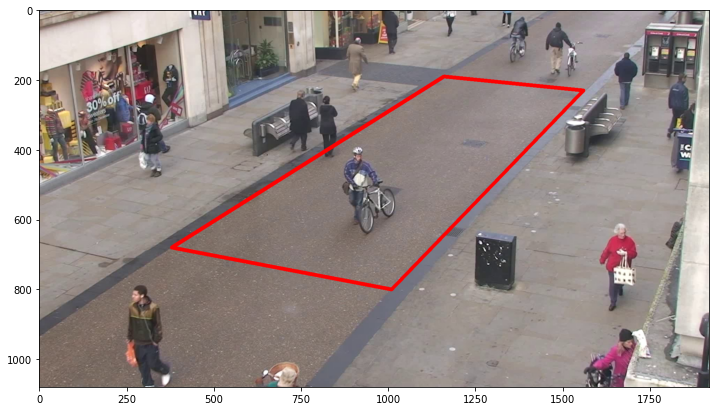

In [173]:
plt.figure(figsize=(12,12))
plt.imshow(image_calibration)
plt.show()

In [0]:
def unwarp(img, roi_corners):
    src = np.float32(roi_corners)
    warped_size=(img.shape[1], img.shape[0])
    #print("Original:", warped_size)
    #offset=int(warped_size[0]/2.4)
    #dst = np.float32([[offset               , 0               ], 
    #                  [warped_size[0]-offset, 0               ],  
    #                  [warped_size[0]-offset, warped_size[1]  ], 
    #                  [offset               , warped_size[1]  ]])
    dest = np.float32([
                       [],
                       [],
                       [],
                       []
                       ])
    print(dst)
    tansform = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, tansform, warped_size)
    return warped

Original: (1920, 1080)
[[ 800.    0.]
 [1120.    0.]
 [1120. 1080.]
 [ 800. 1080.]]


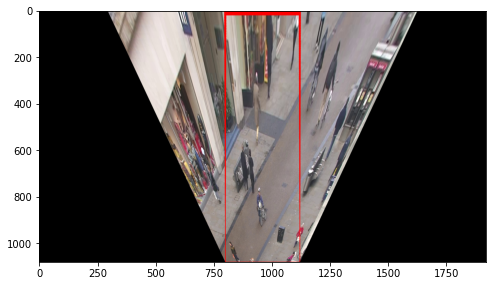

In [163]:
image = unwarp(image_calibration, roi_corners)
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

###2. Detector de personas con YOLOv3


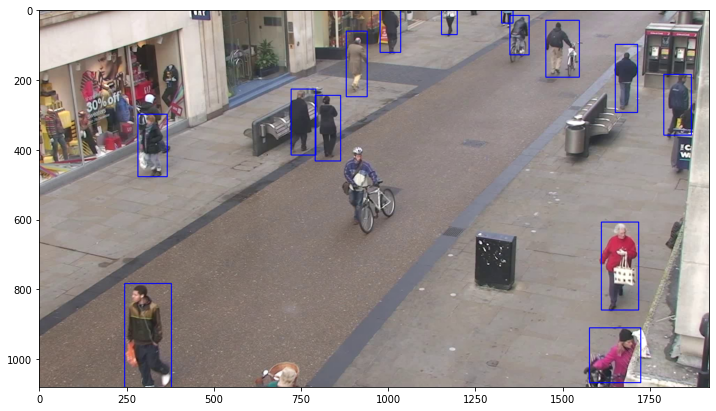

In [252]:
#Referencia: https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/
confidence_threshold = 0.5
nms_threshold = 0.5
input_width = 416
input_height = 416
model_config_name = 'yolov3.cfg'
model_weights_name = 'yolov3.weights'
model_classes_name = 'coco.names'
classes = None
with open(model_classes_name, 'rt') as f:
  classes = f.read().strip('\n').split('\n')


#W = None
#H = None
#writer = None

"""
video = cv2.VideoCapture('TownCentreXVID.avi')

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]
  
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output_video.avi', fourcc, 30, (W, H), True)
  
  img_color = cv2.cvtColor(frame, cv2.COLOR_GBR2RGB)
"""

# Step 1: Create the model
model = cv2.dnn.readNetFromDarknet(model_config_name, model_weights_name)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Step 2: Get the Output Layers
layer_names = model.getLayerNames()
output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]

# Step 3: Read the image or frame (video)
image = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB)

# Step 4: Create blob from image or frame
blob = cv2.dnn.blobFromImage(image, 
                             1/255., 
                             (input_width, input_height), 
                             [0,0,0],
                             1,
                             crop=False)

# Step 5: Set input to model and do forward pass
model.setInput(blob)
outputs = model.forward(output_names)

# Step 6: Apply non maximum supression
#frame = image, outs = outputs
img_height = image.shape[0]
img_width = image.shape[1]
classIds = []
confidences = []
boxes = []
for output in outputs:
  for detection in output:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > confidence_threshold:
      center_x = int(detection[0] * img_width)
      center_y = int(detection[1] * img_height)
      width = int(detection[2] * img_width)
      height = int(detection[3] * img_height)
      left = int(center_x - width / 2)
      top = int(center_y - height / 2)
      classIds.append(classId)
      confidences.append(float(confidence))
      boxes.append([left, top, width, height])

indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

# Step 7: Draw Bounding boxes
for index in indices:
  index = index[0]
  i_class = classes[classIds[index]]
  if i_class == 'person':  
    box = boxes[index]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    cv2.rectangle(image, (left, top), (left + width, top + height), (0,0,255), 2)
    #i_label = f'{confidences[index]:.2f}'
    #label = f'{str(i_class)}:{str(i_label)}'
    #label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.)
    #top = max(top, label_size[1])
    #cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,255))

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()